# Credit Card Fraud Detection with AutoXGB

## Part 2 - Baseline Model: XGBoost with RandomizedSearchCV
___

### Import dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
print(xgb.__version__)

1.5.1


If you are running this notebook on Colab, make sure to upgrade the XGBoost version (default version on Colab is 0.90) using `!pip install xgboost --upgrade`

In [3]:
# !pip install xgboost --upgrade

In [4]:
# Import processed datasets
main_df = pd.read_csv('data/processed/train.csv')
test_df = pd.read_csv('data/processed/test.csv')

In [5]:
main_df.head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
0,120.26,1,0,3.0,8.0,36.0,113.393333,120.136250,107.220278,1.0,5.0,30.0,0.0,0.0,0.0,0
1,25.16,0,0,3.0,15.0,45.0,62.430000,73.638000,70.424667,1.0,9.0,35.0,0.0,0.0,0.0,0
2,139.69,0,1,4.0,25.0,98.0,111.137500,75.406000,113.727245,1.0,2.0,18.0,0.0,0.0,0.0,0
3,60.47,0,0,7.0,28.0,101.0,45.312857,40.015714,44.085050,0.0,7.0,29.0,0.0,0.0,0.0,0
4,45.12,0,0,3.0,20.0,91.0,104.186667,88.629000,91.904176,0.0,7.0,30.0,0.0,0.0,0.0,0


### Data Preparation

In [6]:
# Define target variable
target = 'TX_FRAUD'

In [7]:
# View labels
main_df[target].value_counts(dropna=False)

0    55060
1    27530
Name: TX_FRAUD, dtype: int64

In [8]:
# Set X and y datasets
X = main_df.drop(columns=target)
y = main_df[target]

### Run XGBoost Classification

In [9]:
# Set parameter grid
xgb_params = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1),
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # Number of features supplied to a tree
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),
              'n_estimators': np.arange(100, 600, 100),
              'gamma': np.arange(0, 0.7, 0.1) }

In [10]:
# Create RandomizedSearchCV instance
xgb_grid = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      tree_method="gpu_hist", # Use GPU
                                                      random_state=42,
                                                      eval_metric='aucpr'), # AUC under PR curve
                              param_distributions=xgb_params, 
                              cv=5, 
                              verbose=2,
                              n_iter=60,
                              scoring='average_precision') 

In [11]:
%%time

# Run XGBoost grid search
xgb_grid.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, gamma=0.4, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   3.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, gamma=0.4, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, gamma=0.4, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, gamma=0.4, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, gamma=0.4, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.6000000000000001, learning

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,...
                   param_distributions={'colsample_bylevel': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.3, 0.4,

In [12]:
# Best parameters from RandomizedSearchCV
xgb_grid.best_params_

{'colsample_bylevel': 0.8000000000000003,
 'colsample_bytree': 0.7000000000000002,
 'gamma': 0.30000000000000004,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 200,
 'subsample': 0.8999999999999999}

In [13]:
# Get best XGBoost model (based on best parameters) and predict on test set
xgb_best = xgb_grid.best_estimator_

### Predict on Test Set

In [14]:
# Set X and y datasets
X_test = test_df.drop(columns=target)
y_test = test_df[target]

# Get predictions from best model
preds_proba = xgb_best.predict_proba(X_test)
preds_proba

array([[0.94811124, 0.05188874],
       [0.98284775, 0.01715226],
       [0.9962515 , 0.00374849],
       ...,
       [0.9828856 , 0.01711441],
       [0.9867477 , 0.01325229],
       [0.95593274, 0.04406728]], dtype=float32)

In [15]:
y_preds_proba = preds_proba[:,1]
y_preds_proba

array([0.05188874, 0.01715226, 0.00374849, ..., 0.01711441, 0.01325229,
       0.04406728], dtype=float32)

In [16]:
preds = xgb_best.predict(X_test)
preds

array([0, 0, 0, ..., 0, 0, 0])

### Review performance metrics

In [17]:
# Define function to consolidate and display performance metrics
def gen_performance_metrics(y_true, y_preds, y_preds_proba, model_name, round_to=3):
    accuracy = round(metrics.accuracy_score(y_true, y_preds), round_to)
    f1_score = round(metrics.f1_score(y_true, y_preds), round_to)
    roc_auc = round(metrics.roc_auc_score(y_true, y_preds_proba), round_to)
    avg_precision = round(metrics.average_precision_score(y_true, y_preds_proba), round_to)

    df = pd.DataFrame([[model_name, accuracy, f1_score, roc_auc, avg_precision]], 
                        columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC Score', 'Average Precision'])
    
    display(df)
    display(metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_preds))

,Model,Accuracy,F1 Score,ROC AUC Score,Average Precision
0,XGBoost + RandomizedSearchCV,0.995,0.716,0.915,0.776


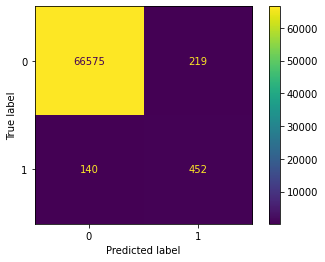

In [18]:
# Show performance assessment
gen_performance_metrics(y_test, preds, y_preds_proba, 'XGBoost + RandomizedSearchCV')

In [ ]:
# Save best model as JSON file
model_filename = 'xgb_baseline.json'
xgb_best.save_model(f'models/{model_filename}')

# Load model
# xgb_best = XGBClassifier()
# xgb_best.load_model(f'models/{model_filename}')